In [1]:
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib
import os

from skimage import measure
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
from scipy import interpolate, signal
from matplotlib.animation import FuncAnimation, PillowWriter  
from matplotlib import patches

plt.style.use('seaborn-whitegrid')

res = 320
device = 'cpu'#torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
model = torch.load(f'../train/best_model.pth', map_location=device)

In [3]:
fp_in = 'test_input2.mp4'

vidcap = cv2.VideoCapture(fp_in)
frameCount = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
frameRate = int(vidcap.get(cv2.CAP_PROP_FPS))
video = torch.empty((frameCount, 3, res, res))

success = True
i = 0
while success:
    success, frame = vidcap.read()
    if success:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (res, res))
        frame = transforms.ToTensor()(frame)
        video[i] = frame
        i += 1

In [4]:
frameCount

275

In [5]:
video.shape

torch.Size([275, 3, 320, 320])

In [6]:
dataloader = DataLoader(video, batch_size=64)

In [7]:
mask = torch.empty((frameCount, 2, res, res), dtype=torch.float64)
filledTo = 0
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(device)
        size = batch.shape[0]
        pred = model(batch)

        # add pred to mask
        mask[filledTo:(filledTo + size)] = pred.cpu().detach()
        filledTo += size

    del batch, pred, model
    torch.cuda.empty_cache()

    mask = mask.numpy()
    video = video.numpy()

In [8]:
mask.shape

(275, 2, 320, 320)

# Generating Test Gif

In [33]:
def create_gif(video, mask, savepath = '../../docs/test_out.gif', frameReduction = 5):
    centers = []
    step = frameReduction
    imgs = []
    for idx in range(0, frameCount, step):
        size = 16
        ratio = 4
        plt.figure(figsize=(size, size/ratio))

        loc = 141

        ax1 = plt.subplot(loc)
        ax1.set_axis_off()
        ax1.imshow(video[idx].transpose(1, 2, 0))
        ax1.set_title('Video Input')

        ax2 = plt.subplot(loc + 1)
        ax2.set_axis_off()
        ax2.imshow(mask[idx, 0] - mask[idx, 1], cmap='bwr')
        ax2.set_title('Prediction Mask')
        
        ax3 = plt.subplot(loc + 2)
        ax3.set_axis_off()
        ax3.set_title('Fit Ellipse and Center')
        
        img = np.zeros((320, 320))
        
        center = np.empty((2, 2))
        
        # inside ellipse
        try:
            contours, _ = cv2.findContours(np.array(mask[idx, 0]*255, dtype=np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            largest = np.argmax([cv2.contourArea(c) for c in contours])
            ellipse = cv2.fitEllipse(contours[largest])
            cv2.ellipse(img, ellipse, color=(1, 0, 0), thickness=2)
            
            ax3.axhline(y=ellipse[0][1], color='r', linestyle='--', linewidth=1)
            ax3.axvline(x=ellipse[0][0], color='r', linestyle='--', linewidth=1)
            
            center[0] = ellipse[0]
        except Exception as e:
            print(f'\nerror on frame {idx}\n{e}')
        
        # outside ellipse
        try:
            contours, _ = cv2.findContours(np.array(mask[idx, 1]*255, dtype=np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            largest = np.argmax([cv2.contourArea(c) for c in contours])
            ellipse = cv2.fitEllipse(contours[largest])
            cv2.ellipse(img, ellipse, color=(-1, 0, 0), thickness=2)
            
            ax3.axhline(y=ellipse[0][1], color='r', linestyle='--', linewidth=1)
            ax3.axvline(x=ellipse[0][0], color='r', linestyle='--', linewidth=1)
            
            center[1] = ellipse[0]
        except Exception as e:
            print(f'\nerror on frame {idx}\n{e}')
            
        ax3.imshow(img, cmap='bwr')
        
        ax4 = plt.subplot(loc + 3)
        ax4.set_axis_off()
        
        centers.append(center)
        
        data = np.array(centers)
        ax4.imshow(np.zeros((320, 320)))
        ax4.plot(data[:, 0, 0], data[:, 0, 1], 'r', linewidth=1)
        ax4.plot(data[:, 1, 0], data[:, 1, 1], 'b', linewidth=1)
        ax4.plot(data[:,:,0].mean(axis=1),data[:,:,1].mean(axis=1), 'g', linewidth=2)
        
        
        ax4.set_xbound(0, 320)
        ax4.set_ybound(0, 320)
        ax4.set_title('Track Path and Mean')
        

        plt.savefig(f'tmp/{idx}.png', bbox_inches='tight', facecolor = 'white', pad_inches = 0.2)
        plt.close()
        imgs.append(Image.open(f'tmp/{idx}.png'))
        print(ellipse)
    imgs[0].save(savepath, format='GIF', append_images=imgs[1:], save_all=True, duration=step*1000/frameRate, loop=0)

In [34]:
create_gif(video, mask, savepath='output.gif', frameReduction=60)

((186.42674255371094, 282.81390380859375), (71.72142028808594, 74.15782928466797), 162.153076171875)
((212.973388671875, 190.89637756347656), (67.8158187866211, 73.28702545166016), 170.63795471191406)
((228.35137939453125, 101.82916259765625), (65.49888610839844, 78.33720397949219), 168.2132110595703)
((224.96607971191406, 103.92220306396484), (68.8849105834961, 76.83715057373047), 167.177734375)
((247.82911682128906, 40.02434539794922), (66.71859741210938, 75.49879455566406), 171.3357391357422)


In [26]:
center = np.empty((frameCount, 2, 2))
box = np.empty((frameCount, 2, 4))
area = mask[:, :2].sum(axis=(2, 3))

idx = 0
for frame in mask:
    center[idx, 0, :] = measure.centroid(frame[0])[::-1]
    center[idx, 1, :] = measure.centroid(frame[1])[::-1]

    contour = measure.find_contours(frame[0])[0], measure.find_contours(frame[1])[0]

    box[idx] = np.stack((
        np.concatenate((contour[0].min(axis=0), contour[0].max(axis=0))),
        np.concatenate((contour[1].min(axis=0), contour[1].max(axis=0))),
        ))

    idx += 1

center = center/res
center[:, :, 1] = 1 - center[:, :, 1]
center = signal.savgol_filter(center, 5, 2, axis=0, mode='nearest')

Plot of height and width of both sides in pixels (default image res is 320x320).

(275, 2, 2)


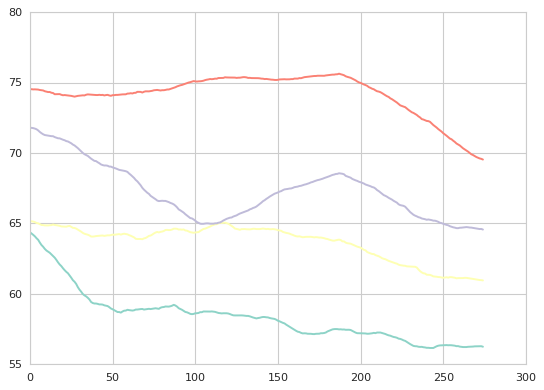

In [178]:
dim = np.stack((box[:, :, 3] - box[:, :, 1], box[:, :, 2] - box[:, :, 0]), axis=-1)
dim = signal.savgol_filter(dim, 50, 1, axis=0, mode='nearest')

print(dim.shape)

plt.plot(np.concatenate((dim[:, 0], dim[:, 1]), axis=1))

Median dimensions of plates as a percent of the frame.

In [179]:
expectedDim = np.quantile(dim.mean(axis=1), 0.50, axis=0)/res
expectedDim

array([0.1954206, 0.2170065])

Coefficients to convert x and y units into meters.

In [180]:
coef = 0.450/expectedDim
print(coef)
center_m = np.multiply(center, coef)

[2.30272553 2.07367064]


In [40]:
np.percentile(area, [1])

array([4.88483318])

In [181]:
#center_m[area < 100] = np.nan
#center_m[diff > 0.1] = np.nan

In [182]:
center_m.shape

(275, 2, 2)

In [183]:
position = center_m.mean(axis=1) - center_m.mean(axis=1).min(axis=0)
position.shape

(275, 2)

This plot includes the inside, outside, and averaged paths.

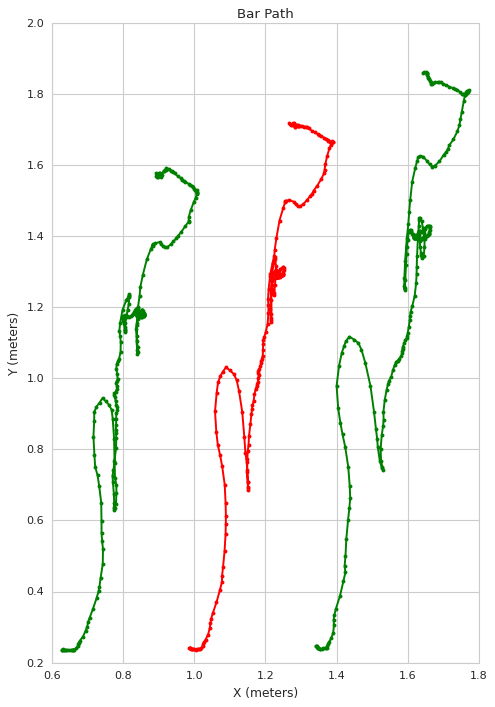

In [425]:
fig = plt.figure(facecolor='w', figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

plt.plot(center_m.mean(axis=1)[:, 0], center_m.mean(axis=1)[:, 1], marker='.', color = 'red')
plt.plot(center_m[:, :, 0], center_m[:, :, 1], marker='.', color='green')

ax.set_title('Bar Path')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

#plt.savefig('output.png', transparent=False, dpi = 100, bbox_inches='tight')
plt.show()

In [185]:
# create time series
length = frameCount/frameRate
t = np.linspace(0, length, frameCount)
td = 0.01
tn = np.arange(0, length, td)

# create spline, interpolate, and smooth
splinefn = interpolate.make_interp_spline(t, position, axis=0, k=3)
pos_spline = splinefn(tn)
pos_smooth = signal.savgol_filter(pos_spline, 30, 3, axis=0, mode='nearest')

# velocity and acceleration
vel = np.diff(pos_smooth, axis=0)/td
accel = np.diff(vel, axis=0)/td

vel_smooth = signal.savgol_filter(vel, 50, 2, axis=0, mode='interp')
accel_smooth = signal.savgol_filter(accel, 75, 1, axis=0, mode='constant')

# make dataframe
df = pd.DataFrame(np.concatenate((tn.reshape(-1, 1)[1:-1], pos_smooth[1:-1], vel_smooth[:-1], accel_smooth), axis=1), columns=['t', 'x', 'y', 'vx', 'vy', 'ax', 'ay'])

In [186]:
df

,t,x,y,vx,vy,ax,ay
0,0.01,0.000199,0.004799,-0.012926,-0.004537,0.138587,0.042444
1,0.02,0.000160,0.004732,-0.005979,-0.007420,0.133959,0.057542
2,0.03,0.000176,0.004629,0.000747,-0.010089,0.129038,0.071637
3,0.04,0.000254,0.004488,0.007253,-0.012543,0.124519,0.083385
4,0.05,0.000397,0.004316,0.013538,-0.014782,0.120718,0.092375
...,...,...,...,...,...,...,...
910,9.11,0.285079,1.477483,-0.066367,0.007714,-0.005428,0.004882
911,9.12,0.284368,1.477363,-0.068048,0.006664,-0.016552,0.003276
912,9.13,0.283695,1.477321,-0.069816,0.005558,-0.021107,0.004014
913,9.14,0.283077,1.477378,-0.071672,0.004397,-0.020862,0.006824


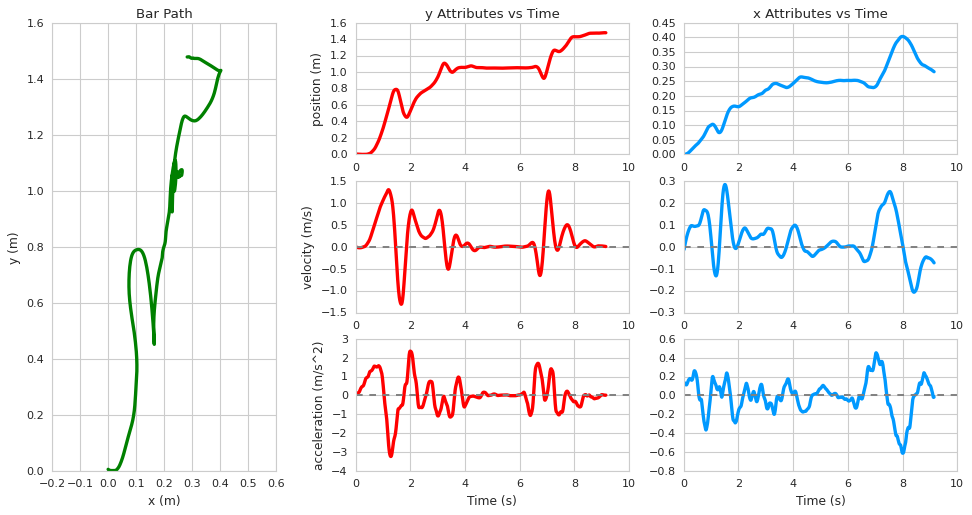

In [441]:

def plot_trajectory(df, style = 'seaborn-whitegrid' , save=False):
    colors = ['green', 'red', '#0099ff']
    lwd = 3
    
    plt.style.use(style)
    plt.figure(figsize=(15, 7), facecolor='white')
    ax1 = plt.subplot(131)
    ax1.set_aspect('equal')
    ax1.plot(df.x, df.y, color=colors[0], linewidth=lwd)
    ax1.set_title('Bar Path')
    ax1.set_xbound(-0.2, 0.6)

    ax2 = plt.subplot(332)
    ax2.plot(df.t, df.y, color = colors[1], linewidth=lwd)
    ax2.set_title('y Attributes vs Time')

    ax3 = plt.subplot(333)
    ax3.plot(df.t, df.x, color = colors[2], linewidth=lwd)
    ax3.set_title('x Attributes vs Time')

    ax4 = plt.subplot(335)
    ax4.plot(df.t, df.vy, color = colors[1], linewidth=lwd)

    ax5 = plt.subplot(336)
    ax5.plot(df.t, df.vx, color = colors[2], linewidth=lwd)

    ax6 = plt.subplot(338)
    ax6.plot(df.t, df.ay, color = colors[1], linewidth=lwd)

    ax7 = plt.subplot(339)
    ax7.plot(df.t, df.ax, color = colors[2], linewidth=lwd)

    ax2.set_ylabel('position (m)')
    ax4.set_ylabel('velocity (m/s)')
    ax6.set_ylabel('acceleration (m/s^2)')

    ax1.set_xlabel('x (m)')
    ax1.set_ylabel('y (m)')

    ax6.set_xlabel('Time (s)')
    ax7.set_xlabel('Time (s)')
    
    for ax in [ax4, ax5, ax6, ax7]:
        ax.axhline(y = 0, color = 'gray', linestyle = 'dashed')
        
    if save:
        plt.savefig('../../docs/output.png', transparent=False, dpi = 300, bbox_inches='tight', facecolor='white')
        plt.close()
    else:
        plt.show()
        
#plot_trajectory(df, save=True)
plot_trajectory(df)

In [188]:
combined = video.copy()
#combined[:, :2][mask[:, :2] > 0.01] = mask[:, :2][mask[:, :2] > 0.01]/2
combined = combined*255
combined = combined.astype(np.uint8)
combined = np.swapaxes(combined, 1, -1)
combined = np.swapaxes(combined, 1, 2)

imgs = []
for idx, img in enumerate(combined):
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)

    cx = center[idx, :, 0]*res
    cy = (1 - center[idx, :, 1])*res

    draw.line([(cx[0], cy[0]), (cx[1], cy[1])], fill=(0, 0, 255), width=2)

    size = 5
    inside = (cx[0] - size, cy[0] - size, cx[0] + size, cy[0] + size)
    outside = (cx[1] - size, cy[1] - size, cx[1] + size, cy[1] + size)

    draw.ellipse(inside, fill=(0, 200, 0))
    draw.ellipse(outside, fill=(0, 200, 0))

    draw.ellipse(np.mean((inside, outside), axis=0).tolist(), fill=(255, 0, 0))

    imgs.append(img)

In [189]:
imgs[0].save("test_out.gif", save_all=True, append_images=imgs[::2], duration=2*1000/frameRate, loop=0)

<img src="../test_out.gif" width="500" align="center"> 